## 2. Predicting house price with location 

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline

### Import 

In [2]:
# Check dataset 2 info: 
pd.read_excel("data/real-estate-2.xlsx").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8606 entries, 0 to 8605
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   8606 non-null   object 
 1   property_type               8606 non-null   object 
 2   place_with_parent_names     8606 non-null   object 
 3   lat-lon                     6950 non-null   object 
 4   price                       7611 non-null   float64
 5   currency                    7611 non-null   object 
 6   price_aprox_local_currency  7611 non-null   float64
 7   price_aprox_usd             7611 non-null   float64
 8   surface_total_in_m2         5958 non-null   float64
 9   surface_covered_in_m2       7293 non-null   float64
 10  price_usd_per_m2            4852 non-null   float64
 11  price_per_m2                6532 non-null   float64
 12  floor                       1339 non-null   float64
 13  rooms                       4772 

In [3]:
def wrangle(filepath):
    df = pd.read_excel(filepath)

    # Subset data: houses 
    mask_house = df["property_type"] == "house"

    df = df[mask_house]

    # Remove outliers in "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon"
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df.drop(columns = "lat-lon", inplace = True) # Drop the old column 

    # Drop n/a 
    df.dropna(subset = ["price_aprox_usd", "lat", "lon"], inplace = True)

    return df 

In [4]:
frame1 = wrangle("data/real-estate-1.xlsx")
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1353 entries, 2 to 8600
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1353 non-null   object 
 1   property_type               1353 non-null   object 
 2   place_with_parent_names     1353 non-null   object 
 3   price                       1353 non-null   float64
 4   currency                    1353 non-null   object 
 5   price_aprox_local_currency  1353 non-null   float64
 6   price_aprox_usd             1353 non-null   float64
 7   surface_total_in_m2         1170 non-null   float64
 8   surface_covered_in_m2       1353 non-null   float64
 9   price_usd_per_m2            1084 non-null   float64
 10  price_per_m2                1353 non-null   float64
 11  floor                       7 non-null      float64
 12  rooms                       642 non-null    float64
 13  expenses                    44 non-nul

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,lat,lon
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,-34.649700,-58.658073
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,-34.595709,-58.566950
7,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Ituzaingó|,130000.0,USD,1971112.0,130000.0,300.0,140.0,433.333333,928.571429,NaN,NaN,NaN,-34.655209,-58.697320
12,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,230000.0,USD,3487352.0,230000.0,290.0,230.0,793.103448,1000.000000,NaN,5.0,NaN,-34.652173,-58.577867
21,sell,house,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,340000.0,USD,5155216.0,340000.0,200.0,200.0,1700.000000,1700.000000,NaN,NaN,NaN,-34.417629,-58.645755


In [5]:
frame2 = wrangle("data/real-estate-2.xlsx")
frame2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1326 entries, 15 to 8603
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1326 non-null   object 
 1   property_type               1326 non-null   object 
 2   place_with_parent_names     1326 non-null   object 
 3   price                       1326 non-null   float64
 4   currency                    1326 non-null   object 
 5   price_aprox_local_currency  1326 non-null   float64
 6   price_aprox_usd             1326 non-null   float64
 7   surface_total_in_m2         1155 non-null   float64
 8   surface_covered_in_m2       1326 non-null   float64
 9   price_usd_per_m2            1072 non-null   float64
 10  price_per_m2                1326 non-null   float64
 11  floor                       3 non-null      float64
 12  rooms                       646 non-null    float64
 13  expenses                    46 non-nu

In [6]:
# Concatenate frame1 and frame2 into df, and ignore index 
df = pd.concat([frame1, frame2], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2679 non-null   object 
 1   property_type               2679 non-null   object 
 2   place_with_parent_names     2679 non-null   object 
 3   price                       2679 non-null   float64
 4   currency                    2679 non-null   object 
 5   price_aprox_local_currency  2679 non-null   float64
 6   price_aprox_usd             2679 non-null   float64
 7   surface_total_in_m2         2325 non-null   float64
 8   surface_covered_in_m2       2679 non-null   float64
 9   price_usd_per_m2            2156 non-null   float64
 10  price_per_m2                2679 non-null   float64
 11  floor                       10 non-null     float64
 12  rooms                       1288 non-null   float64
 13  expenses                    90 no

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,lat,lon
0,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,-34.649700,-58.658073
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,-34.595709,-58.566950
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Ituzaingó|,130000.0,USD,1971112.0,130000.0,300.0,140.0,433.333333,928.571429,NaN,NaN,NaN,-34.655209,-58.697320
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,230000.0,USD,3487352.0,230000.0,290.0,230.0,793.103448,1000.000000,NaN,5.0,NaN,-34.652173,-58.577867
4,sell,house,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,340000.0,USD,5155216.0,340000.0,200.0,200.0,1700.000000,1700.000000,NaN,NaN,NaN,-34.417629,-58.645755


### Explore

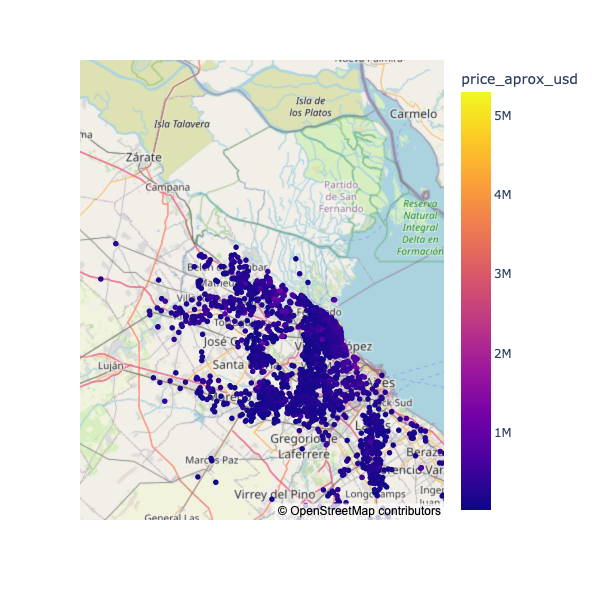

In [7]:
# Plot mapbox location and price 
# use 'color' to show prices
fig = px.scatter_mapbox(
    df, 
    lat = "lat",
    lon = "lon",
    width = 600, 
    height = 600,
    color = "price_aprox_usd",
    hover_data = "price_aprox_usd"
)

fig.update_layout(mapbox_style = "open-street-map")

fig.show()

fig.write_html("images/fig3.1_map.html")
fig.write_image("images/fig3.1_map.png")

# Load and display the image in GitHub
from IPython.display import display, Image 
display(Image(filename='images/fig3.1_map.png'))

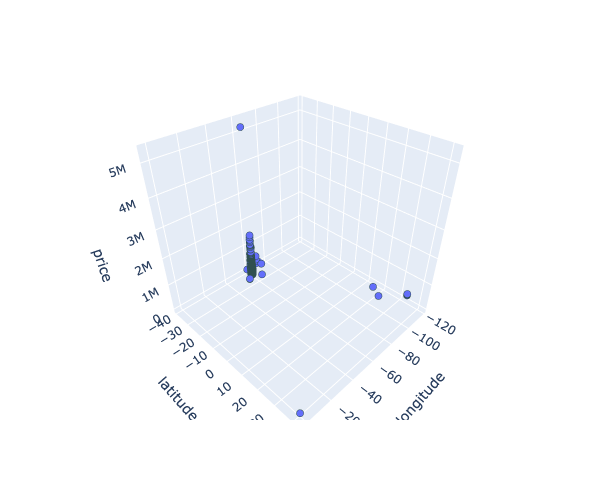

In [8]:
# Create 3D scatter plot 
fig = px.scatter_3d(
    df, 
    x = "lon",
    y = "lat",
    z = "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

fig.write_html("images/fig3.2_3d.html")
fig.write_image("images/fig3.2_3d.png")

# Load and display the image in GitHub
from IPython.display import display, Image 
display(Image(filename='images/fig3.2_3d.png'))

### Split

In [9]:
features = ["lon", "lat"]
X_train = df[features]
X_train.shape

(2679, 2)

In [10]:
target = "price_aprox_usd" # One dimension 
y_train = df[target]
y_train.shape

(2679,)

### Baseline

In [11]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[np.float64(285427.6318962299),
 np.float64(285427.6318962299),
 np.float64(285427.6318962299),
 np.float64(285427.6318962299),
 np.float64(285427.6318962299)]

In [12]:
# Calculate the baseline mean absolute error
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 285427.63
Baseline MAE: 136034.78


### Pipeline

In [13]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

In [14]:
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [15]:
print(model.fit(X_train, y_train))

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])


### Evaluate 

In [16]:
# Using model's predict method, create a list of predictions for the observations
y_pred_training = model.predict(X_train)

In [17]:
# Calculate the training mean absolute error for predictions 
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 135969.62


In [18]:
# import test data buenos-aires-test-features.csv into a DataFrame and generate a Series of predictions using the model
X_test = pd.read_excel("data/test-features.xlsx")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    285092.500493
1    285194.436345
2    285101.981814
3    285114.279491
4    285137.059974
dtype: float64

### Communicate Results

In [19]:
# Access the LinearRegression step
linear_regression_model = model.named_steps['linearregression']

# Get the intercept
intercept = linear_regression_model.intercept_

coefficients = linear_regression_model.coef_

In [20]:
print(
    
    f"price = {round(intercept, 2)} + ({round(coefficients[0], 2)} * longitude) + ({round(coefficients[1], 2)} * latitude)"
)

price = 279991.86 + (-519.79 * longitude) + (729.02 * latitude)


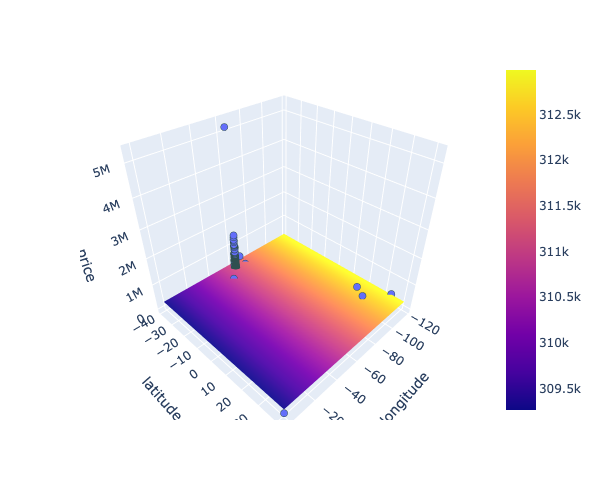

In [21]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="lon",
    y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Create x and y coordinates for model representation
x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Use model to predict z coordinates
z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

# Add plane to figure
fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

fig.write_html("images/fig3.3_3d.html")
fig.write_image("images/fig3.3_3d.png")

# Load and display the image in GitHub
from IPython.display import display, Image 
display(Image(filename='images/fig3.3_3d.png'))